In [1]:

import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as rutils
import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook

In [3]:
import matplotlib.ticker as ticker

def format_ticks(x):
    return '%.1f' % round(x, 2)

In [4]:
def smooth_phase_nans(inputArray, sigma, sz):
    
    V=inputArray.copy()
    V[np.isnan(inputArray)]=0
    VV=smooth_phase_array(V,sigma,sz)

    W=0*inputArray.copy()+1
    W[np.isnan(inputArray)]=0
    WW=smooth_phase_array(W,sigma,sz)

    Z=VV/WW

    return Z

In [5]:

def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        if np.isnan(inputArray).any():
            print("... phase, found nans")
            outputArray = smooth_phase_nans(inputArray, sigma, sz)
        else:
            outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


In [6]:


def get_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True):
    phase_az = mapdata['phaseMap'].copy()
    mag_az = mapdata['magRatioMap'].copy()

    if smooth_fwhm is not None:
        phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
        mag_az = smooth_array(mag_az, smooth_fwhm)

    if recenter:
        phaseC_az=np.copy(phase_az)
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        phasemin = 0
        phasemax = 2*np.pi
    else:
        phaseC_az = np.copy(phase_az)
        phasemin = -np.pi
        phasemax = np.pi


    phaseC_az[mag_az<mag_thr]=np.nan
    
    return phaseC_az, mag_az, phasemin, phasemax



In [7]:
def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res

def block_mean_stack(stack0, ds_factor, along_axis=2):
    if along_axis==2:
        im0 = block_mean(stack0[:,:,0],ds_factor) 
        print im0.shape
        stack1 = np.zeros((im0.shape[0],im0.shape[1],stack0.shape[2]))
        for i in range(0,stack0.shape[2]):
            stack1[:,:,i] = block_mean(stack0[:,:,i],ds_factor) 
    else:
        # This is for downsampling masks:
        im0 = block_mean(stack0[0,:,:],ds_factor) 
        print "... block mean on MASKS by %i (target: %s)" % (ds_factor, str(im0.shape))

        stack1 = np.zeros((stack0.shape[0], im0.shape[0], im0.shape[1]))
        for i in range(stack0.shape[0]):
            stack1[i,:,:] = block_mean(stack0[i,:,:],ds_factor) 

    return stack1

# set output dir

In [8]:
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'


# Select colormap

In [9]:
# Load colormap
colormap = 'nic_Edge'
cmapdir = os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

    

# Select dataset

In [10]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC085'
session = '20190525' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'
data_identifier = '|'.join([animalid, session, fov, retinorun])


# Get screen info

In [11]:

# adjust elevation limit to show only monitor extent
screeninfo_fpath = glob.glob(os.path.join(rootdir, animalid, 'epi_maps', '*.json'))[0]
with open(screeninfo_fpath, 'r') as f:
    screen = json.load(f)

screen_width = screen['screen_params']['screen_size_x_degrees']
screen_height = screen['screen_params']['screen_size_t_degrees']

screen_left = -1*screen_width/2.
screen_right = screen_width/2.
screen_top = screen_height/2.
screen_bottom = -1*screen_height/2.
    
elev_cutoff = screen_top / screen_right
print("[AZ]: screen bounds: (%.2f, %.2f)" % (screen_left, screen_right))
print("[EL]: screen bounds: (%.2f, %.2f)" % (screen_top, screen_bottom))


[AZ]: screen bounds: (-58.78, 58.78)
[EL]: screen bounds: (33.66, -33.66)


In [12]:
screen_x = 59.7782*2 #119.5564
screen_y =  33.6615*2. #67.323
resolution = [1920, 1080] #[1024, 768]
print(screen_x, screen_y)

(119.5564, 67.323)


# Set output dirs

In [13]:
outdir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)


# Legends

In [14]:
deg_per_pixel_x = screen_x / float(resolution[0])
deg_per_pixel_y = screen_y / float(resolution[1])

print(deg_per_pixel_x, deg_per_pixel_y)

deg_per_pixel = np.mean([deg_per_pixel_x, deg_per_pixel_y])

(0.06226895833333333, 0.062336111111111106)


In [15]:
x = np.linspace(0, 2*np.pi, int(round(screen_x)))
y = np.linspace(0, 2*np.pi, int(round(screen_y)) )

xv, yv = np.meshgrid(x, y)


az_legend = (2*np.pi) - xv
el_legend = yv


In [16]:
az_screen = convert_range(az_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)
el_screen = convert_range(el_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)


In [17]:
def save_legend(az_screen, cmap, cmap_name='cmap_name', cond='cond', outdir='/tmp'):
    fig, ax = pl.subplots()
    im = ax.imshow(az_screen, cmap=cmap)
    #ax.invert_xaxis()
    pl.colorbar(im)
    ax.set_xticks(np.linspace(0, int(round(screen_x)), 5))
    ax.set_xticklabels([int(round(i)) for i in np.linspace(0, int(round(screen_x)), 5)][::-1])

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', length=0)
    ax.set_frame_on(False)
    ax.set_xlim(ax.get_xlim()[::-1])

    figname = '%s_pos_%s_LEGEND_abs' % (cond, cmap_name)
    pl.savefig(os.path.join(outdir, '%s.svg' % figname))

    print outdir, figname


<IPython.core.display.Javascript object>


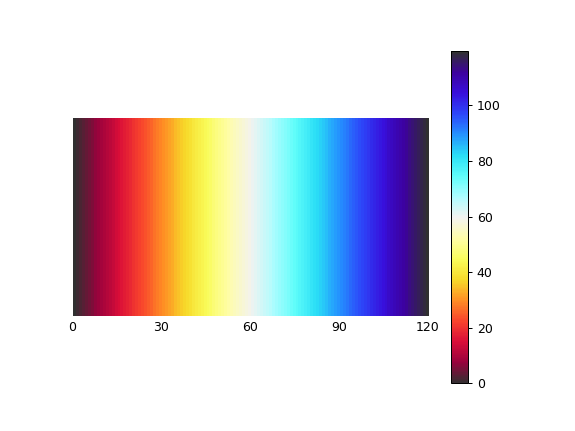

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy azimuth_pos_nic_Edge_LEGEND_abs


<IPython.core.display.Javascript object>


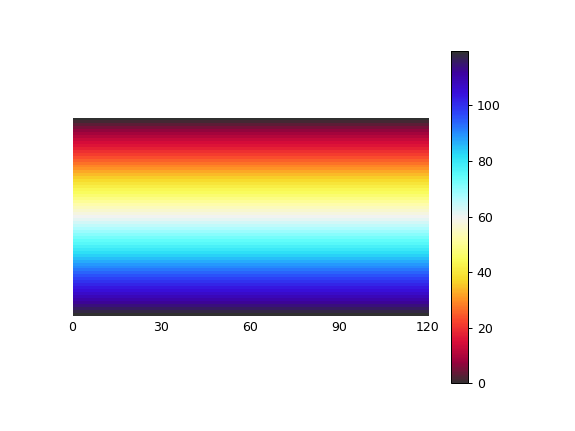

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy elevation_pos_nic_Edge_LEGEND_abs


In [18]:
save_legend(az_screen, cmap=cmap_phase, cmap_name=colormap, cond='azimuth', outdir=outdir)
save_legend(el_screen, cmap=cmap_phase, cmap_name=colormap, cond='elevation', outdir=outdir)


# Mapping

In [19]:
from pipeline.python.traces import get_traces as gtraces


In [20]:
def load_mw(run_dir):
    print("... loading paradigm info")
    paradigm_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed_trials*.json'))[0]
    with open(paradigm_fpath, 'r') as r: mwinfo = json.load(r)
    return mwinfo

def load_si(run_dir):
    print('... loading scan info')
    simeta_path = glob.glob(os.path.join(run_dir, '*.json'))[0]
    with open(simeta_path, 'r') as r:
        scaninfo = json.load(r)
    return scaninfo

# Get retino run info

In [21]:
# reload(rutils)

### Get retino run info

In [22]:
traceid = 'traces001'

run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
RETID = rutils.load_retinoanalysis(run_dir, traceid)
analysis_dir = RETID['DST']
retinoid = RETID['analysis_id']
print("Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))

data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("data ID: %s" % data_id)

# Load MW info and SI info
mwinfo = load_mw(run_dir)
scaninfo = rutils.get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
tiff_paths = tiff_fpaths = sorted(glob.glob(os.path.join(RETID['SRC'], '*.tif')), key=natural_keys)
print("Found %i tifs" % len(tiff_paths))

Corresponding ANALYSIS ID (for traces001 with rois001) is: analysis002
{   u'DST': u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068',
    u'PARAMS': {   u'average_frames': u'5',
                   u'downsample_factor': u'2',
                   u'excluded_tiffs': [],
                   u'hashid': u'5f8f45',
                   u'minus_rolling_mean': True,
                   u'rid_hash': u'd27901',
                   u'roi_id': u'rois001',
                   u'roi_type': u'manual2D_circle',
                   u'signal_channel': 1,
                   u'smooth_fwhm': None,
                   u'tiff_source': u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/processed/processed001_0dd42c/mcorrected_79c82b'},
    u'SRC': u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/processed/processed001_0dd42c/mcorrected_79c82b',
    u'analysis_hash': u'9bb068',
    u'analysis_id': u'analysis002'}
Loaded: retino_run1, analysis002 (/n

In [23]:
# avgtraces = retinoutils.get_condition_averaged_traces(RETID, analysis_dir, mwinfo, scaninfo, tiff_paths, create_new=False)
# avgtraces.keys()

trials_by_cond = scaninfo['trials']
for k, v in trials_by_cond.items():
    print("...%s: %i reps" % (k, len(v)))

...top: 3 reps
...right: 3 reps
...left: 3 reps
...bottom: 3 reps


## Get ROI masks

In [24]:
roiid = RETID['PARAMS']['roi_id']

# Load reference image
imgs = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun, 'processed',\
                      'processed001*', 'mcorrected_*', 'std_images.tif'))[0]
zimg = tf.imread(imgs)
zimg = zimg.mean(axis=0)

ds_factor = int(RETID['PARAMS']['downsample_factor'])
if ds_factor is not None:
    zimg = block_mean(zimg, int(ds_factor))
d1, d2 = zimg.shape

print("FOV size: %s (downsample factor=%i)" % (str(zimg.shape), ds_factor))

FOV size: (256, 256) (downsample factor=2)


<IPython.core.display.Javascript object>


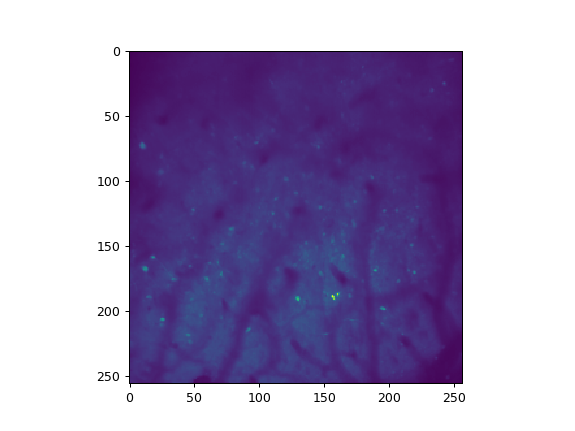

In [25]:
pl.figure()
pl.imshow(zimg)

# Set output dir for retino structure analysis

In [26]:
retino_outdir = os.path.join(analysis_dir, 'retino-structure')
if not os.path.exists(retino_outdir):
    os.makedirs(retino_outdir)
print(retino_outdir)

/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure


# Process raw traces

In [27]:
# reload(rutils)

In [28]:
#### Set TRACE TYPE
trace_type = 'neuropil'
add_offset = True

# Some preprocessing params
temporal_ds = float(RETID['PARAMS']['average_frames'])
print("Temporal ds: %.2f" % (temporal_ds))

Temporal ds: 5.00


In [29]:
#### Load raw dataa
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')

#### Process traces -- returns average trace for condition
np_traces = rutils.load_retino_traces(retino_dpath, scaninfo, trace_type='neuropil', temporal_ds=temporal_ds)
soma_traces = rutils.load_retino_traces(retino_dpath, scaninfo, trace_type='raw', temporal_ds=temporal_ds)


... loading cond: top
Performing temporal smoothing on traces...
... loading cond: right
Performing temporal smoothing on traces...
... loading cond: left
Performing temporal smoothing on traces...
... loading cond: bottom
Performing temporal smoothing on traces...
... loading cond: top
Performing temporal smoothing on traces...
... loading cond: right
Performing temporal smoothing on traces...
... loading cond: left
Performing temporal smoothing on traces...
... loading cond: bottom
Performing temporal smoothing on traces...


<IPython.core.display.Javascript object>


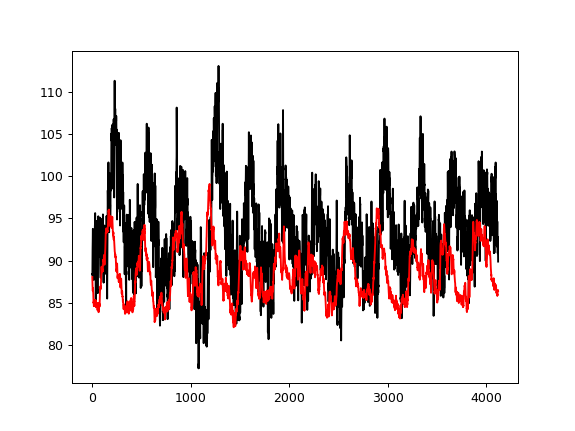

In [41]:
pl.figure()
pl.plot(soma_traces['right'][32], 'k', label='soma')
pl.plot(np_traces['right'][32], 'r', label='neuropil')

# Do fft

In [30]:
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']

#### label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate))
sorted_freq_idxs = np.argsort(freqs)


fft_soma = dict((cond, rutils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, rutils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())


In [31]:
fft_soma['right'][1].shape

(238,)

## Get average magratios

In [32]:
# Create dataframe of magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))

magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))


In [33]:
# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

In [34]:
# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]
for roi in sorted_rois_soma[0:10]:
    print(roi, mean_magratio_values_soma[roi], mean_magratio_values_np[roi])

(113, 0.080904085483623489, 0.044095874936829212)
(157, 0.075619302131139501, 0.056458687192284647)
(192, 0.07526752344252044, 0.054097309994696564)
(112, 0.070092475017106068, 0.046810234590640529)
(126, 0.066620531262053889, 0.055614653619983412)
(177, 0.059152665031577387, 0.062771370543052124)
(82, 0.055816226744599524, 0.06644238015177921)
(60, 0.055563593942217764, 0.070224630734418134)
(50, 0.053014813347268819, 0.050039775005285746)
(117, 0.04878269958477454, 0.064720959114578105)


## Visualize example cells

In [35]:
### Convert raw/processed traces to df/f
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in soma_traces.items())
dff_np = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in np_traces.items())

In [36]:
### set min to 0 for visualization
dff_soma_vis = dict((k, dff_soma[k] - dff_soma[k].min()) for k in dff_soma.keys())
dff_np_vis = dict((k, dff_np[k] - dff_np[k].min()) for k in dff_np.keys())


In [37]:
dst_dir = os.path.join(retino_outdir, 'example_traces')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


<IPython.core.display.Javascript object>


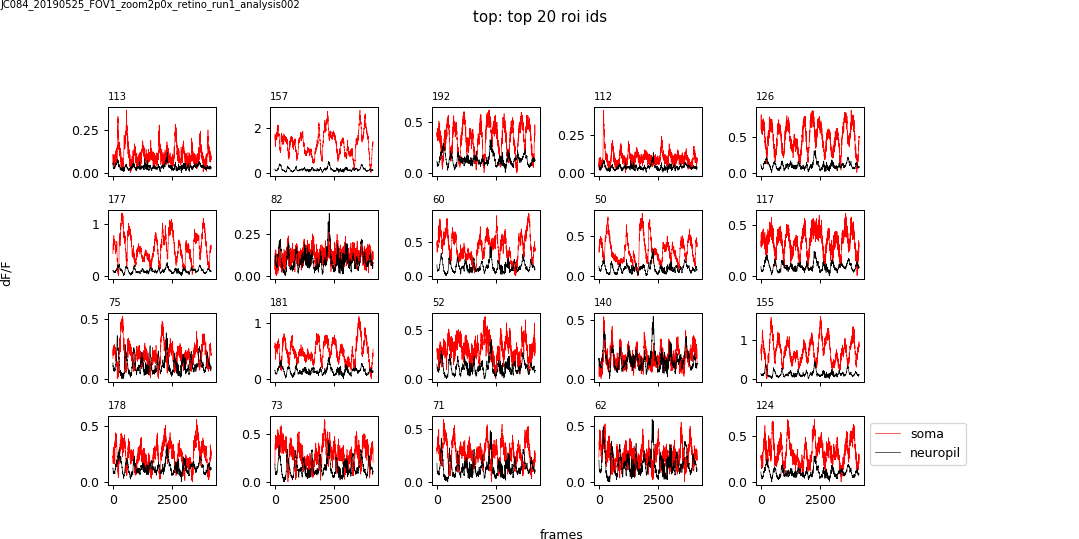

<IPython.core.display.Javascript object>


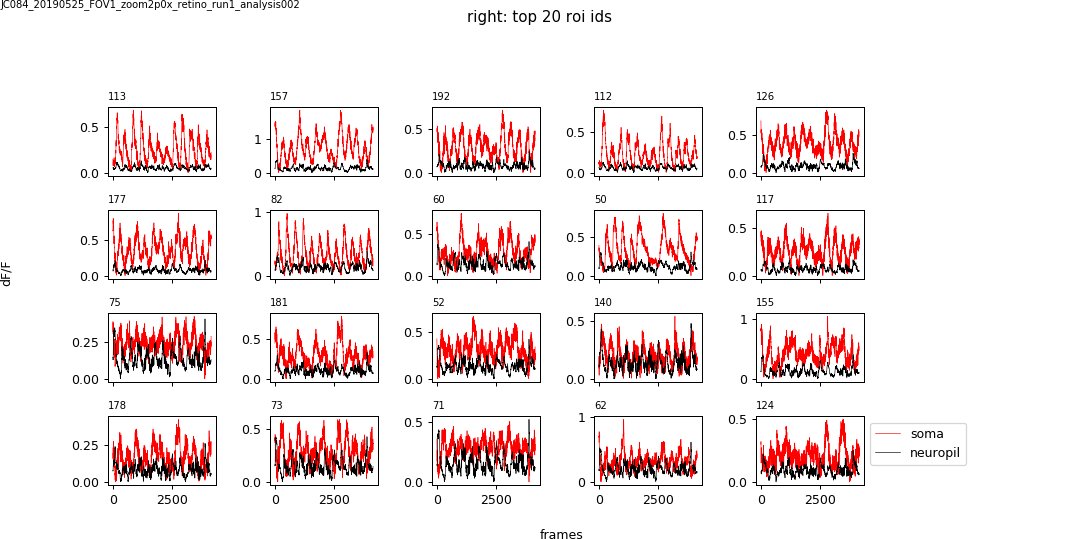

<IPython.core.display.Javascript object>


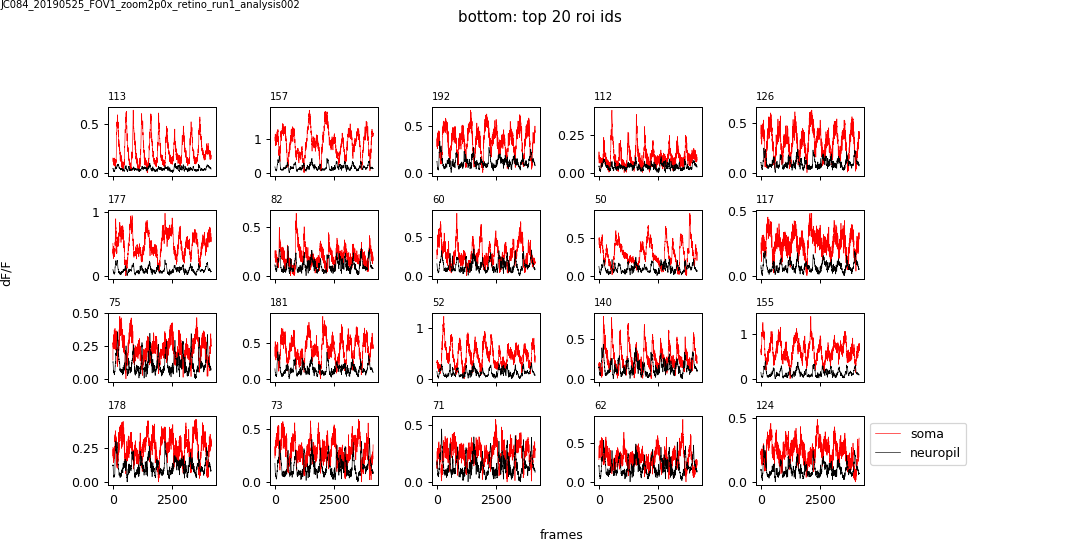

<IPython.core.display.Javascript object>


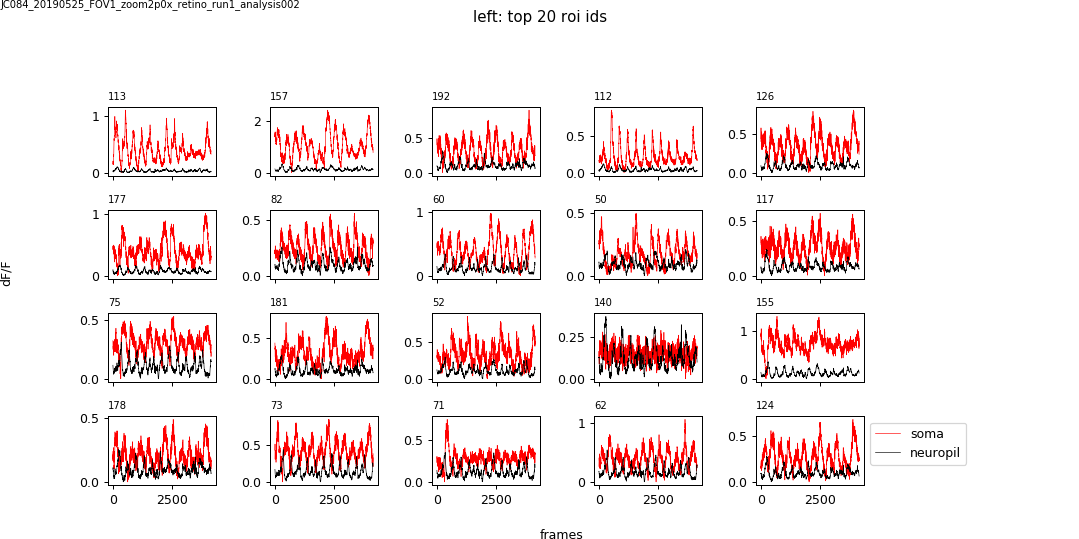

In [50]:
nrois_plot = 20
nr = 4
nc = 5

for cond in dff_soma_vis.keys():
    fig, axes = pl.subplots(nr, nc, sharex=True, sharey=False, figsize=(12,6))
    for ax, roi in zip(axes.flat, sorted_rois_soma[0:nrois_plot]):
        ax.plot(dff_soma_vis[cond][roi], lw=0.5, color='r', label='soma')
        ax.plot(dff_np_vis[cond][roi], lw=0.5, color='k', label='neuropil')
        ax.set_title(roi, fontsize=8, loc='left')
    pl.subplots_adjust(top=0.8, bottom=0.1, right=0.8, left=0.1,  hspace=0.5, wspace=0.5)
    ax.legend(bbox_to_anchor=(1.0, 1))
    label_figure(fig, data_id)
    fig.text(0, 0.5, 'dF/F', rotation=90)
    fig.text(0.5, 0., 'frames', rotation=0)

    pl.suptitle('%s: top %i roi ids' % (cond, nrois_plot))
    
    pl.savefig(os.path.join(dst_dir, 'top%i_cells_%s.png' % (nrois_plot, cond)))
    
    

#### Plot average traces

In [35]:
scaninfo['stimulus']

{'cycle_start_ixs': array([   0,  343,  686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430,
        3773]),
 'frame_rate': 44.6528,
 'freqs': array([  1.08327996e-02,   2.16655992e-02,   3.24983988e-02, ...,
          2.22939016e+01,   2.23047344e+01,   2.23155672e+01]),
 'n_cycles': 12,
 'n_frames': 4122,
 'n_frames_per_cycle': 343,
 'n_reps': 3,
 'stim_freq': 0.13,
 'stim_freq_idx': 11}

In [35]:
rois_plot = sorted_rois_soma[0:3]
colors = ['royalblue', 'darkorange', 'forestgreen']

<IPython.core.display.Javascript object>


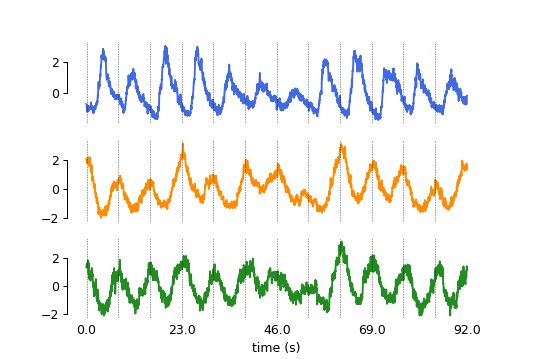

Text(0.5,0,u'time (s)')

In [37]:
cycle_starts = scaninfo['stimulus']['cycle_start_ixs']
xticks = np.linspace(0, n_frames, 5)
xticklabels = [round(float(f)/frame_rate) for f in xticks]


fig, axes = pl.subplots(3, 1, figsize=(6,4), sharex=True, sharey=False)
for ri, (ax, roi) in enumerate(zip(axes, rois_plot)):
    meanval = soma_traces['right'][roi].mean()
    stdval = soma_traces['right'][roi].std()
    ax.plot( (soma_traces['right'][roi]-meanval) / stdval , color=colors[ri])
    #ax.plot( (avgtraces_vis['right'][roi]) , color=colors[ri])

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
        
ax.set_xlabel('time (s)')

#figname = 'example-traces_cond-%s_%s' % (currcond, skey)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#print figname

# Compare magratio to df/f

In [36]:
def compare_magratio_dff(mean_magratio_values, dff_traces): #, cond='right'):

    fig, axes = pl.subplots(1,2, figsize=(7, 4)) #.figure()
    axes[0].hist(mean_magratio_values)
    axes[0].set_title('mag-ratios')
    axes[1].scatter(dff_traces.max(axis=0), mean_magratio_values, s=5)

    #axes[1].scatter(dff_traces[cond].max(axis=0), mean_magratio_values, s=5)
    axes[1].set_xlabel('dff')
    axes[1].set_ylabel('mag-ratio')
    pl.subplots_adjust(wspace=0.5, top=0.8)

    return fig

In [39]:
mean_dff_soma = pd.DataFrame(np.mean(np.dstack(dff_soma.values()), axis=-1))
mean_dff_np = pd.DataFrame(np.mean(np.dstack(dff_np.values()), axis=-1))

#mean_dff_soma.shape



NameError: name 'dff_soma' is not defined

In [40]:
fig =  compare_magratio_dff(mean_magratio_values_soma, mean_dff_soma) #, cond='right')
fig.suptitle('soma')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(retino_outdir, 'magratio-v-dff_all-conds_soma.png'))

NameError: name 'mean_dff_soma' is not defined

In [41]:
fig =  compare_magratio_dff(mean_magratio_values_np, mean_dff_np) #, cond='right')
fig.suptitle('neuropil')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(retino_outdir, 'magratio-v-dff_all-conds_np.png'))

NameError: name 'mean_dff_np' is not defined

# Plot roi maps

In [37]:
# def mask_rois(masks, value_array, mask_thr=0.1. average_overlap=False):
#     nrois, d1, d2 = masks.shape
#     dims = (d1, d2)

#     if average_overlap:
#         value_mask = np.empty(masks.shape)
#         for rid in value_array.index.tolist():
#             value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

#     else:
#         value_mask =  np.ones(dims)*-100
#         for rid in value_array.index.tolist():
#             value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

#     return value_mask


def plot_overlaid_maps(curr_cond, phases, magratios, mag_thr=0.03, mask_thr=0.1):

    phase_array = phases[curr_cond]
    magratio_array = magratios[curr_cond]

    phase_array_cont =  -1 * phase_array
    phase_array_cont = phase_array_cont % (2*np.pi)

    phase_mask_tmp = mask_rois(masks, phase_array_cont, mask_thr=mask_thr)
    magratio_mask_tmp = mask_rois(masks, magratio_array, mask_thr=mask_thr)
    
    phase_mask = np.ma.masked_where(magratio_mask_tmp==-100, phase_mask_tmp)
    magratio_mask = np.ma.masked_where(magratio_mask_tmp==-100, magratio_mask_tmp)
    
    #magratio_mask_thr = np.copy(magratio_mask)
    #magratio_mask_thr[magratio_mask<mag_thr] = np.nan
    magratio_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, magratio_mask)
    print("max magratio:", magratio_array.max())

    #phase_mask_thr = np.copy(phase_mask)
    #phase_mask_thr[magratio_mask<mag_thr] = np.nan
    phase_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, phase_mask)
    print("max phase:", phase_mask_thr.max())


    fig, axes = pl.subplots(1,3, figsize=(12,5))
    ax = axes[0]
    im = ax.imshow(cnm.estimates.Cn, cmap='gray'); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[1]
    axes[1].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(magratio_mask_thr, cmap='inferno', alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[2]
    axes[2].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(phase_mask_thr, cmap='nipy_spectral', vmin=0, vmax=2*np.pi, alpha=0.7); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig


In [38]:
def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
#     a = np.zeros((5, 5))
#     struct1 = ndimage.generate_binary_structure(2, 1)
    
#     kernel = ndimage.binary_dilation(a, structure=struct1, iterations=sigma).astype(a.dtype)
    
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

In [39]:
import scipy.stats as spstats
def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



In [40]:
def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1):
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    
    # Get full array to average across overlapping pixels
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        #avg_azim[ix] = spstats.circmean([v for v in azim_phase2[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

# Filter cells

In [41]:
mag_thr=0.01 #if trace_type == 'neuropil' else 0.02
all_conds_pass = True
if all_conds_pass:
    roi_list = [i for i in magratios_soma.index if all(magratios_soma.loc[i] >= mag_thr)]
    
print("%i out of %i cells pass mag-ratio thr (thr>=%.2f)" % (len(roi_list), len(mean_magratio_values_soma), mag_thr))

81 out of 238 cells pass mag-ratio thr (thr>=0.01)


# Get mask info

In [42]:
# Get masks
tfile = h5py.File(retino_dpath, 'r')

rid_fpath = glob.glob(os.path.join(rootdir, animalid, session, 'ROIs', 'rids*.json'))[0]
with open(rid_fpath, 'r') as f:
    rids = json.load(f)
reffile = rids[roiid]['PARAMS']['options']['ref_file']

#if trace_type == 'neuropil':
masks_np = tfile['File%03d' % int(reffile)]['np_masks'][:].T
masks_soma = tfile['File%03d' % int(reffile)]['masks'][:].copy()
print("NP masks:", masks_np.shape)
#else:
#    tmpm = tfile['File%03d' % int(reffile)]['masks'][:].copy()

nrois_total, _ = masks_soma.shape
masks_np = np.reshape(masks_np, (nrois_total, d1, d2))
masks_np[masks_np>0] = 1
#if trace_type=='neuropil':
masks_soma = np.reshape(masks_soma, (nrois_total, d1, d2))
masks_soma[masks_soma>0] = 1
print(masks_soma.shape)

print( tfile['File%03d' % int(reffile)].keys())

('NP masks:', (238, 65536))
(238, 256, 256)
[u'corrected', u'masks', u'neuropil', u'np_masks', u'np_subtracted', u'processed', u'raw']


In [43]:
retino_outdir

u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure'

<IPython.core.display.Javascript object>


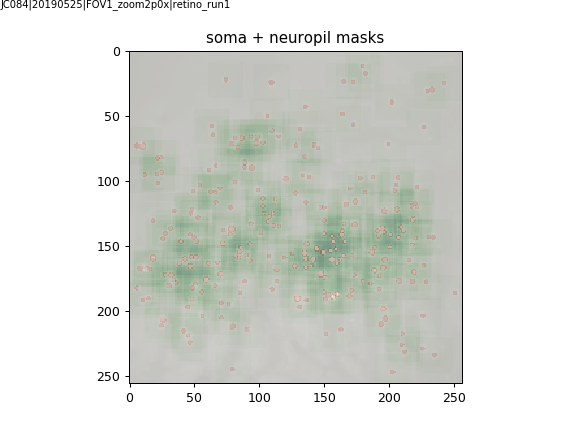

In [44]:
fig = pl.figure()
pl.imshow(zimg, cmap='gray', alpha=0.5)
pl.imshow(masks_np.sum(axis=0), cmap='Greens', alpha=0.4)
#if trace_type == 'neuropil':
pl.imshow(masks_soma.sum(axis=0), cmap='Reds', alpha=0.2)
#pl.colorbar()
#pl.axis('off')
pl.title('soma + neuropil masks')
label_figure(fig, data_identifier)

pl.savefig(os.path.join(retino_outdir, 'soma-v-neuropil-masks.png'))

# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

In [45]:
import imutils
from pipeline.python import utils as putils

from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage

In [46]:
pixel_size = putils.get_pixel_size()
print(pixel_size)

um_per_pixel = np.mean(pixel_size)


(2.31, 1.89)


In [47]:
desired_radius_um = 20.0
pixels2dilate = desired_radius_um/um_per_pixel
print(pixels2dilate)

9.52380952381


(11, 11)


<IPython.core.display.Javascript object>


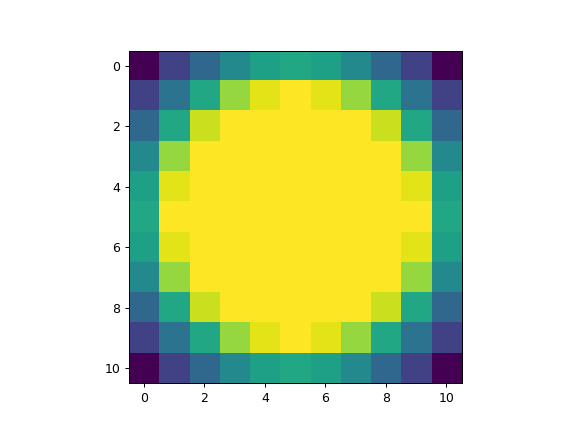

Dilation diameter (um): 23.10


In [48]:
# a = np.zeros((sigma, sigma))
# a[int(np.floor(sigma/2.)), int(np.floor(sigma/2.))] = 1
# struct1 = ndimage.generate_binary_structure(2, 1)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

#kernel = ndimage.binary_dilation(a, structure=struct1, iterations=sigma/2)

kernel_size = np.ceil(pixels2dilate+2) #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# let's create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
# using ... allows compatibility with arbitrarily-shaped radius arrays

kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
print(kernel.shape)
pl.figure()
pl.imshow(kernel)
kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Dilation diameter (um): %.2f" % kernel_diam_um)

## Dilate all masks with kernel

<IPython.core.display.Javascript object>


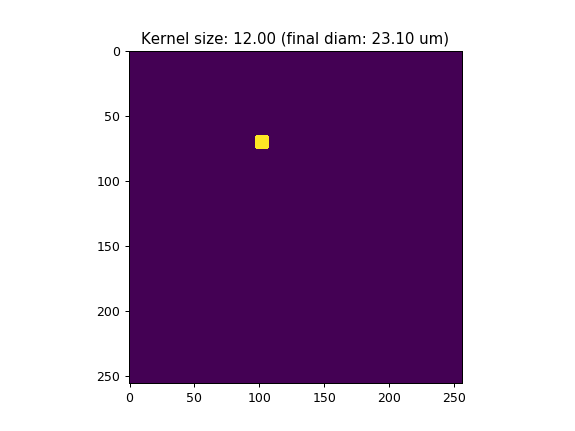

10
10


In [49]:
#if trace_type == 'neuropil':
rid = 33
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)
pl.figure()
pl.imshow(dilated_masks[rid, :, :])
pl.title("Kernel size: %.2f (final diam: %.2f um)" % (kernel_size, kernel_diam_um))
x, y = np.where(dilated_masks[rid, :, :]>0)
print x.max()-x.min()
print y.max()-y.min()
#else:
#    dilated_masks =  masks.copy() #dilate_mask_centers(masks, kernel_size=5)

# Get phase masks

In [50]:
def get_phase_masks(masks, phases, average_overlap=True, roi_list=None, use_cont=True, mask_thr=0.01):
    # Convert phase to continuous:
    phases_cont = -1 * phases
    phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = phases.index.tolist()
        
    # Get absolute maps:
    if use_cont:
        elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
        azim = (phases_cont['left'] - phases_cont['right']) / 2.
        vmin = -np.pi
        vmax = np.pi
    else:
        # Get absolute maps:
        elev = (phases['bottom'] - phases['top']) / 2.
        azim = (phases['left'] - phases['right']) / 2.
        
        # Convert to continueous:
        elev_c = -1 * elev
        elev_c = elev_c % (2*np.pi)
        azim_c = -1 * azim
        azim_c = azim_c % (2*np.pi)

        vmin = 0
        vmax = 2*np.pi

        azim = copy.copy(azim_c)
        elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev[roi_list], mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev[roi_list], mask_thr=mask_thr)   
    
    #azim_phase_mask = np.ma.masked_where(azim_phase==-100, azim_phase)
    #elev_phase_mask = np.ma.masked_where(elev_phase==-100, elev_phase)
    return azim_phase, elev_phase

# if filter_by_mag:
#     if trace_type == 'neuropil':
#         print("... using np centers")
#         azim_phase = mask_with_overlaps_averaged(dilated_masks, azim[roi_list], mask_thr=mask_thr)
#         elev_phase = mask_with_overlaps_averaged(dilated_masks, elev[roi_list], mask_thr=mask_thr)
#     else:
#         azim_phase = mask_rois(dilated_masks, azim[roi_list], mask_thr=mask_thr)
#         elev_phase = mask_rois(dilated_masks, elev[roi_list], mask_thr=mask_thr)
# else:
#     azim_phase = mask_rois(masks, azim, mask_thr=mask_thr)
#     elev_phase = mask_rois(masks, elev, mask_thr=mask_thr)


In [51]:

# phases_cont_soma = -1 * phases_soma
# phases_cont_soma = phases_cont_soma % (2*np.pi)


# phases_cont_np = -1 * phases_np
# phases_cont_np = phases_cont_np % (2*np.pi)

In [52]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi


azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=None, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)



/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [53]:
print(vmin, vmax)

(-3.141592653589793, 3.141592653589793)


In [54]:
azim_phase_mask_np[~np.isnan(azim_phase_mask_np)].min(), azim_phase_mask_np[~np.isnan(azim_phase_mask_np)].max()

(-0.52521053666543627, 2.2756419215382593)

In [55]:
azim_phase_mask_soma[~np.isnan(azim_phase_mask_soma)].min(), azim_phase_mask_soma[~np.isnan(azim_phase_mask_soma)].max()

(-2.9630789025945519, 2.5133787308166133)

# Check resizing

#### Reshape array, if need

In [56]:
from pipeline.python.coregistration import fov_to_visual_area as coreg

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/coregistration/fov_to_visual_area.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianar

In [85]:
orig_zimg = tf.imread(imgs)
orig_zimg = orig_zimg.mean(axis=0)

<IPython.core.display.Javascript object>


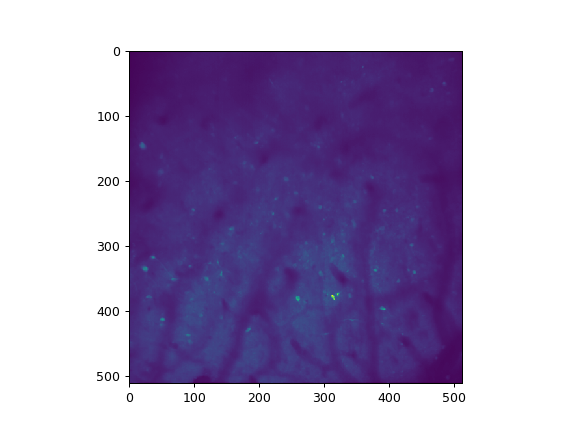

In [86]:
pl.figure()
pl.imshow(orig_zimg)

In [96]:
zimg.shape

(256, 256)

(591, 483)


<IPython.core.display.Javascript object>


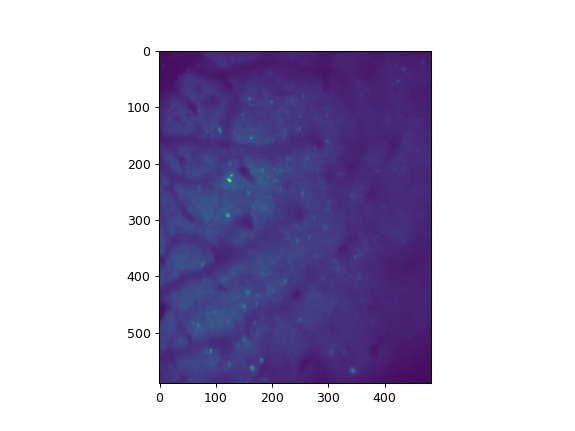

In [57]:
zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg_r.shape)

pl.figure()
pl.imshow(zimg_r)

In [98]:
testout = os.path.join(retino_outdir, 'test_resize.tif')
tf.imsave(testout, zimg_r.astype('int16')) #.astype('uint8'))
print(testout)

/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure/test_resize.tif


# Smooth

In [58]:

def smooth_neuropil(azim_r, smooth_fwhm=21):
    V=azim_r.copy()
    V[np.isnan(azim_r)]=0
    VV=ndimage.gaussian_filter(V,sigma=smooth_fwhm)

    W=0*azim_r.copy()+1
    W[np.isnan(azim_r)]=0
    WW=ndimage.gaussian_filter(W,sigma=smooth_fwhm)

    azim_smoothed = VV/WW
    return azim_smoothed


In [59]:
#azim_smoothed = azim_r.copy() #azim_phase.copy()
#azim_smoothed[azim_r==-100] = np.nan

smooth_fwhm = 7 #21
#azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
azim_smoothed = smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


In [60]:
if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    


In [61]:
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())


(-0.52506772316905703, 2.2756419215382602)


<IPython.core.display.Javascript object>


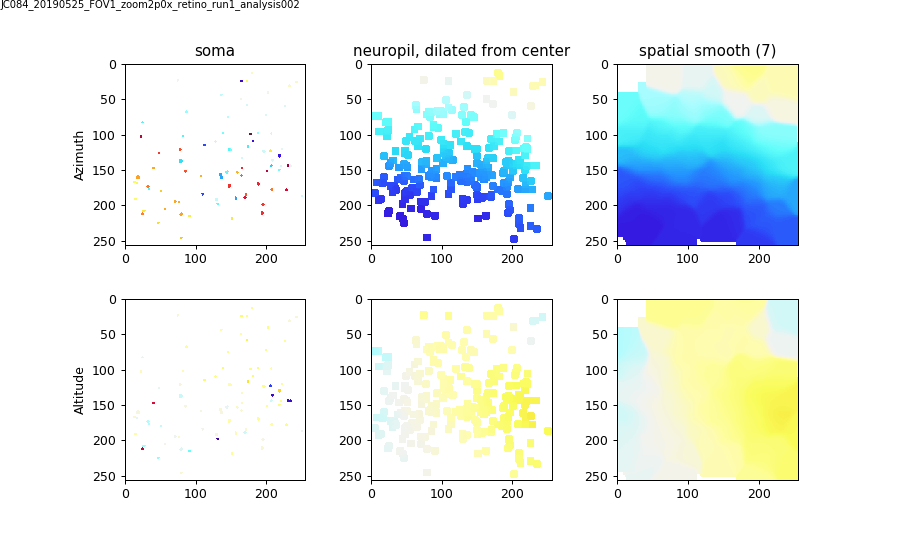

(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'soma-v-neuropil_dilate-center-12_spatial-smooth-7')


In [180]:
fig, axn = pl.subplots(2,3, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('neuropil, dilated from center')

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)


ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
#ax.set_title('soma')
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)
#ax.set_title('neuropil, dilated from center')
#pl.savefig(os.path.join(retino_outdir, 'soma-masks-azim.png'))

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

pl.subplots_adjust(wspace=0.2, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i' % (kernel_size, smooth_fwhm)

pl.savefig(os.path.join(retino_outdir, '%s.png' % figname))
print(retino_outdir, figname)

#### Plot smoothed azimuth neuropil

<IPython.core.display.Javascript object>


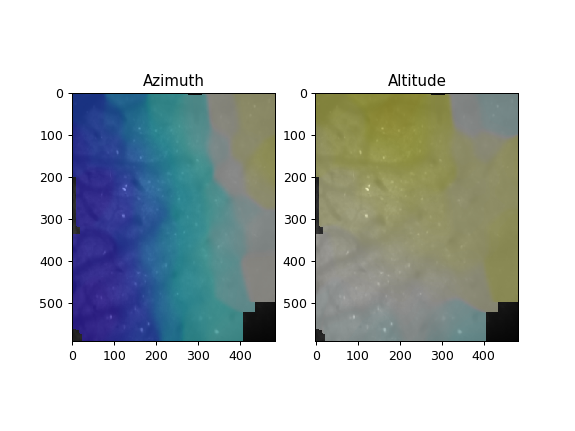

In [373]:
cmap = 'nipy_spectral' # cmap_phase
overlay = True
overlay_str = '_overlay' if overlay else ''
alpha = 0.5 if overlay else 1.0

fig, axn = pl.subplots(1,2)
ax = axn[0]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Azimuth')

ax = axn[1]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Altitude')

figname = 'smoothed_neuropil_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

pl.savefig(os.path.join(retino_outdir, '%s.png' % figname))


# Calculate image gradient

In [404]:
def calculate_gradients(img):
    # Get gradient
    gdy, gdx = np.gradient(img)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(gdx**2 + gdy**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(gradmag)/255
    #gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the x and y gradients
    abs_gdx = np.absolute(gdx)
    abs_gdy = np.absolute(gdy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_gd = np.arctan2(abs_gdy, abs_gdx)

    # Get mean direction
    mean_dir = np.rad2deg(np.arctan2(gdy.mean(), gdx.mean()))
    
    grad_ = {'image': img,
             'magnitude': gradmag,
             'gradient_x': gdx,
             'gradient_y': gdy,
             'mean_deg': mean_dir}
    return grad_


def plot_gradients(grad_, ax=None, draw_interval=3, scale=1, width=0.005, toy=False):
    '''
    scale:  # of dat units per arrow length unit (smaller = longer arrow)
    scale_units 
    weight = width of plot
    '''
    if ax is None:
        fig, ax = pl.subplots()
        
    gradimg = grad_['image']
    mean_dir = grad_['mean_deg']
    gdx = grad_['gradient_x']
    gdy = grad_['gradient_y']
    
    
    # Set limits and number of points in grid
    y, x = np.mgrid[0:gradimg.shape[0], 0:gradimg.shape[1]]

    #ax.quiver(x, y, dx, dy, azim_cont)
    #ax.set(aspect=1, title='Quiver Plot')
    #pl.show()

    # Every 3rd point in each direction.
    skip = (slice(None, None, draw_interval), slice(None, None, draw_interval))
    
    if toy:
        ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k', angles='xy') #, width=width)
    else:
        if scale is not None:

            ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k', scale_units='xy', #units='xy', 
                     angles='xy', scale=scale) 
        else:
            ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k', angles='xy', width=width)

    ax.set(aspect=1, title="Mean dir: %.2f" % mean_dir)

    return ax

#### Test w/ toy example

In [397]:
# Create some images going in various directions
gradimg = np.ones((30, 30))
for i in range(30):
    gradimg[:, i] = gradimg[:, i]*(i**2)
gradimg = gradimg.astype(float)
gradimg_lr = np.fliplr(gradimg.copy()) #gradimg.T
gradimg_ud = gradimg.copy().T
gradimg_du = np.flipud(gradimg_ud)

# Calculate gradients
grad_ = calculate_gradients(gradimg)
grad_lr = calculate_gradients(gradimg_lr)
grad_ud = calculate_gradients(gradimg_ud)
grad_du = calculate_gradients(gradimg_du)


<IPython.core.display.Javascript object>


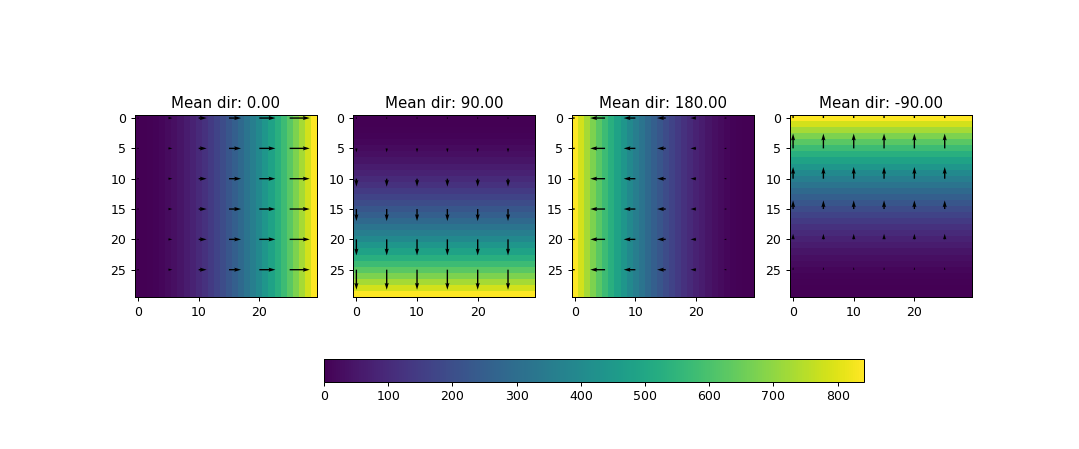

In [425]:
# Yellow = higher #s, arrows should point in direction toward higher
spacing = 5
fig, axn = pl.subplots(1,4, figsize=(12, 5))
cbar_ax = fig.add_axes([0.3, 0.15, 0.5, 0.05])


ax = axn[0]
ax.imshow(grad_['image'])
plot_gradients(grad_, ax=ax,draw_interval=spacing, toy=True)

ax = axn[1]
ax.imshow(grad_ud['image'])
plot_gradients(grad_ud, ax=ax, draw_interval=spacing, toy=True)


ax = axn[2]
ax.imshow(grad_lr['image'])
plot_gradients(grad_lr, ax=ax, draw_interval=spacing, toy=True)


ax = axn[3]
im = ax.imshow(grad_du['image'])
plot_gradients(grad_du, ax=ax, draw_interval=spacing, toy=True)

fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
pl.subplots_adjust(bottom=0.2)

pl.savefig(os.path.join(retino_outdir, 'test_gradient_dirs.png'))

### Do on phase map

In [382]:
from scipy.interpolate import SmoothBivariateSpline

def fill_and_smooth_nas(img):

#     # ---------------
#     x, y = np.meshgrid(np.arange(0, azim_r.shape[1]), np.arange(0, azim_r.shape[0]))
#     z = azim_r.copy()

    y, x = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    x = x.astype(float)
    y = y.astype(float)
    z = img.copy()

    x[np.isnan(z)] = np.nan
    y[np.isnan(z)] = np.nan

    x=x.ravel()
    x=(x[~np.isnan(x)])
    y=y.ravel()
    y=(y[~np.isnan(y)])
    z=z.ravel()
    z=(z[~np.isnan(z)])

    xnew = np.arange(x.min(), x.max()+1) #np.arange(9,11.5, 0.01)
    ynew = np.arange(y.min(), y.max()+1) #np.arange(10.5,15, 0.01)

    f = SmoothBivariateSpline(x,y,z,kx=1,ky=1)
    znew=np.transpose(f(xnew, ynew))


# # --------
#     from scipy.interpolate import griddata
#     znew = griddata((x, y), z, (xnew[None,:], ynew[:,None]), method='linear')

    return znew.T #a


In [383]:
az_fill = fill_and_smooth_nas(azim_r)
el_fill = fill_and_smooth_nas(elev_r)


grad_az = calculate_gradients(az_fill)
grad_el = calculate_gradients(el_fill)


In [384]:
az_fill.min(), az_fill.max()

(-0.67404586555207491, 2.7333208703729808)

<IPython.core.display.Javascript object>


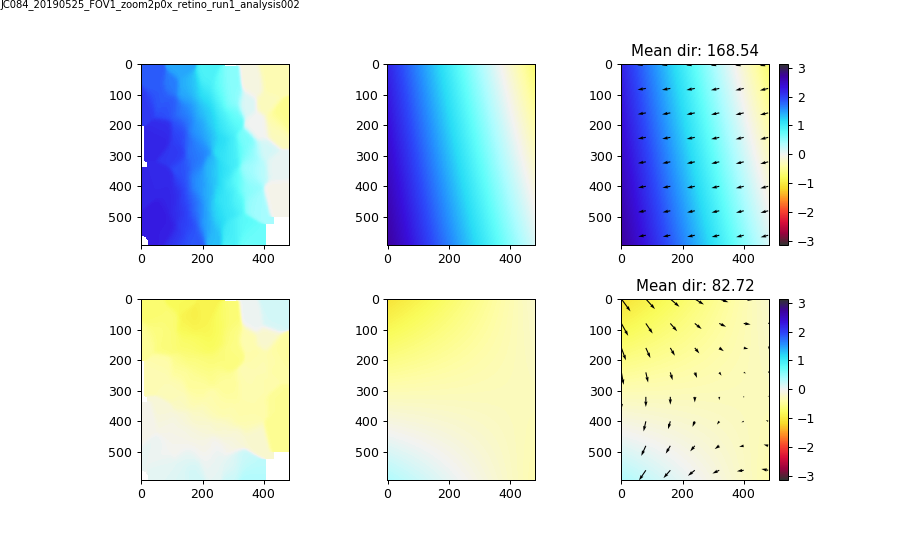

(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'gradients_dilate-center-12_spatial-smooth-7')


In [386]:
spacing = 80
scale = None #0.0001
width = None #0.01

fig, axn = pl.subplots(2, 3, figsize=(10,6))
ax = axn[0, 0]
ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[0,1]
ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[0,2]
im = ax.imshow(grad_az['image'], cmap=cmap_phase, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width)
fig.colorbar(im, ax=ax)

ax = axn[1, 0]
ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1,1]
ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1,2]
im = ax.imshow(grad_el['image'],cmap=cmap_phase, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width)
fig.colorbar(im, ax=ax)


pl.subplots_adjust(wspace=0.2, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i' % (kernel_size, smooth_fwhm)

pl.savefig(os.path.join(retino_outdir, '%s.png' % figname))
print(retino_outdir, figname)

#### Compute unit vector and project

In [239]:
gdx = grad_az['gradient_x']
gdy = grad_az['gradient_y']
gradmag = grad_az['magnitude']
mean_dir = grad_az['mean_deg']

dirvec = np.array([gdx.mean(), gdy.mean()])
vhat = dirvec / (dirvec**2).sum()**0.5
norm = np.linalg.norm(dirvec)
print(vhat)
print(norm, (dirvec**2).sum()**0.5)

[-0.98008045  0.19860089]
(0.0057793775826920695, 0.0057793775826920695)


In [240]:
np.rad2deg(np.arctan2(gdy.mean()/gradmag.mean(), gdx.mean()/gradmag.mean()))

168.54484491018823

In [265]:
az_fill.shape

(591, 483)

<IPython.core.display.Javascript object>


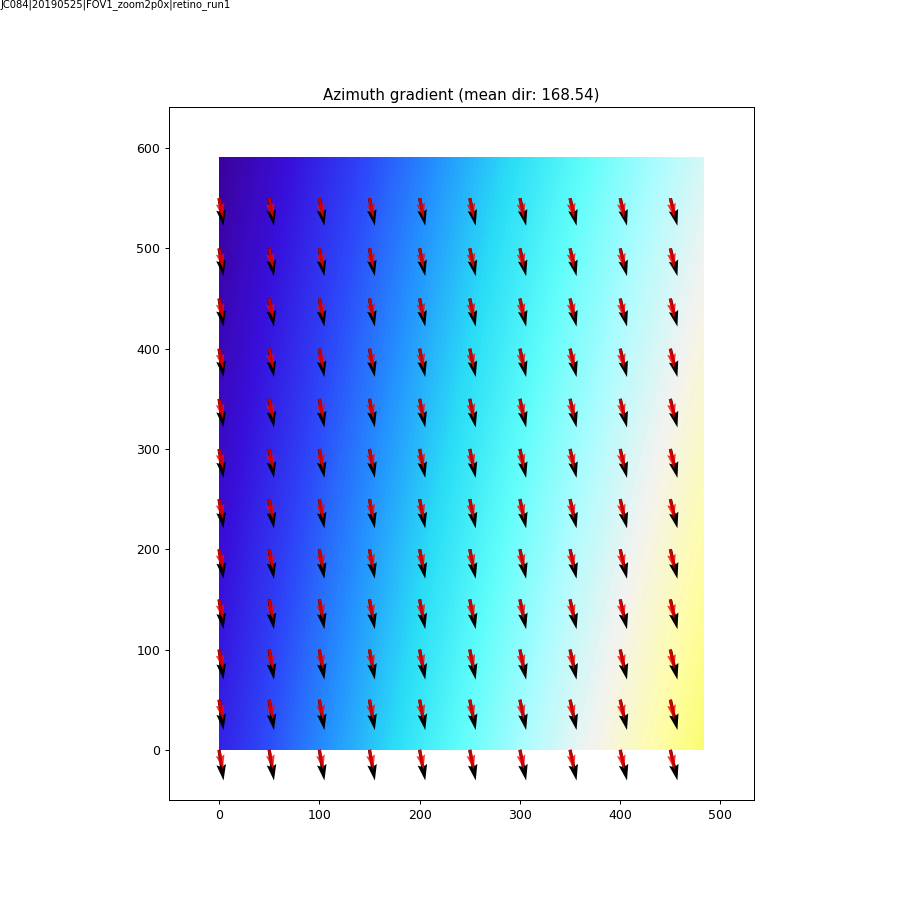

In [276]:
spacing = 50
# Set limits and number of points in grid
y, x = np.meshgrid(np.arange(0, az_fill.shape[1]), np.arange(0, az_fill.shape[0]))
#x = x.astype(float)
#y = y.astype(float)

fig, ax = pl.subplots(figsize=(10,10))
#ax.quiver(x, y, dx, dy, azim_cont)
#ax.set(aspect=1, title='Quiver Plot')
#pl.show()

# Every 3rd point in each direction.
skip = (slice(None, None, spacing), slice(None, None, spacing))

#fig, ax = pl.subplots()
ax.imshow(az_fill, vmin=vmin, vmax=vmax, cmap=cmap_phase, origin='bottom')
ax.set(aspect=1, title='Azimuth gradient (mean dir: %.2f)' % mean_dir)
ax.set_xlim([-50, az_fill.shape[1]+50])
ax.set_ylim([-50, az_fill.shape[0]+50])



ax.quiver(y[skip], x[skip], gdy[skip], gdx[skip], color='k', alpha=1,
         angles='xy') #azim_smoothed[skip], color='k')

#ax.invert_yaxis()
#pl.show()
q = ax.quiver(y[skip], x[skip], np.array((vhat[1])), np.array((vhat[0])), angles='xy', scale_units='xy', 
              alpha=0.8, width=.005, scale=.05, color='r') #, scale_units='xy', scale=1) #units='xy' ,scale=1)

label_figure(fig, data_identifier)
#pl.savefig(os.path.join(retino_outdir, 'dilated-masks-azim_kernel-%i_smooth-fwhm-%i_gradient_vhat.png' % (kernel_size, smooth_fwhm)))



#### Plot direction vector mean 

In [281]:
vhat[1]*r

NameError: name 'r' is not defined

In [288]:
np.dot([gdx[0][0], gdy[0][0]], vhat)


0.0060526775973265556

#### Plot smoothed overlay

In [ ]:
import matplotlib.colors as mcolors


<IPython.core.display.Javascript object>


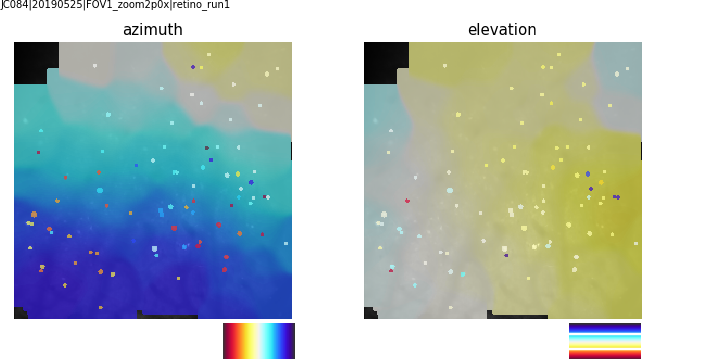

absolute-maps-filter-allconds_both_magthr_0.01_81cells_smoothed


In [394]:
trace_type = 'both'
smooth_np = True
label = False


if trace_type == 'neuropil':
    azim_ = azim_smoothed.copy() if smooth_np else azim_phase_mask_np.copy()
    elev_ = elev_smoothed.copy() if smooth_np else elev_phase_mask_np.copy()
    azim_2 = None
    elev_2 = None
elif trace_type == 'soma':
    azim_ = azim_phase_mask_soma.copy()
    elev_ = elev_phase_mask_soma.copy()
    azim_2 = None
    elev_2 = None
else:
    azim_ = azim_smoothed.copy() if smooth_np else azim_phase_mask_np.copy()
    elev_ = elev_smoothed.copy() if smooth_np else elev_phase_mask_np.copy()
    azim_2 = azim_phase_mask_soma
    elev_2 = elev_phase_mask_soma
    
label_str = '_labeled' if label else ''
norm = mcolors.Normalize(vmin, vmax)
alpha = 0.7
cmap = cmap_phase

fig, axes = pl.subplots(1,2, figsize=(8, 4))
# -- azimuth --
ax = axes[0]
ax.imshow(zimg, cmap='gray'); ax.axis('off');
im1 = ax.imshow(azim_, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('azimuth')
if azim_2 is not None:
    ax.imshow(azim_2, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
    
if label:
    for roi in strong_cells:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')

# -- elevation --
ax = axes[1]
ax.imshow(zimg, cmap='gray'); ax.axis('off');
im2 = ax.imshow(elev_, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('elevation')
if elev_2 is not None:
    ax.imshow(elev_2, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
    
# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.

cbar1_orientation='horizontal'
cbar1_axes = [0.31, -0.001, 0.1, 0.1]
cbar2_orientation='vertical'
cbar2_axes = [0.79, -0.001, 0.1, 0.1]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
#cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
#cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)

pl.subplots_adjust(left=0.01, right=0.9)

if filter_by_mag:
    if all_conds_pass:
        figname = 'absolute-maps-filter-allconds_%s_magthr_%.2f_%icells' % (trace_type, mag_thr, len(roi_list))
    else:
        figname = 'absolute-maps-filter-maxcond_%s_magthr_%.2f_%icells' % (trace_type, mag_thr, len(roi_list))
else:
    figname = 'absolute-maps-all-cells_%s' % trace_type

if smooth_np:
    figname = '%s_smoothed' % figname
    
label_figure(fig, data_identifier)
pl.savefig(os.path.join(retino_outdir, '%s%s.png' % (figname, label_str)))

print(figname)

# Plot individual

In [1113]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

In [1114]:
label = False
label_str = '_labeled' if label else ''
norm = mcolors.Normalize(vmin, vmax)
alpha = 0.7
cmap = cmap_phase

plot_transparent = True
plot_smoothed = True
smooth_fwhm = 25

smooth_str = '_smooth-%i' % smooth_fwhm if plot_smoothed else ''
format_str = '_transparent' if plot_transparent else ''


In [1116]:
# Create smoothed arrays
azim_smoothed = azim_phase.copy()
azim_smoothed[azim_phase==-100] = np.nan

elev_smoothed = elev_phase.copy()
elev_smoothed[elev_phase==-100] = np.nan

#if trace_type == 'neuropil':
azim_smoothed = smooth_neuropil(azim_smoothed, smooth_fwhm)
elev_smoothed = smooth_neuropil(elev_smoothed, smooth_fwhm)

    #azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
    #elev_smoothed = smooth_array(elev_smoothed, smooth_fwhm, phaseArray=True)
    
if 'zoom1p0x' in fov:
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))

<IPython.core.display.Javascript object>


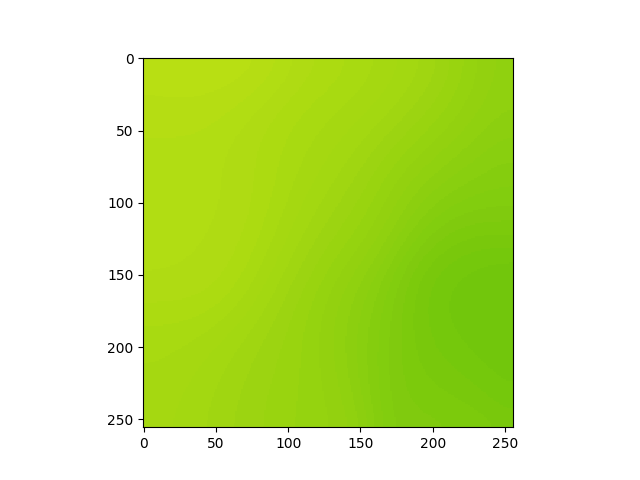

In [1117]:
pl.figure()
pl.imshow(elev_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)

<IPython.core.display.Javascript object>


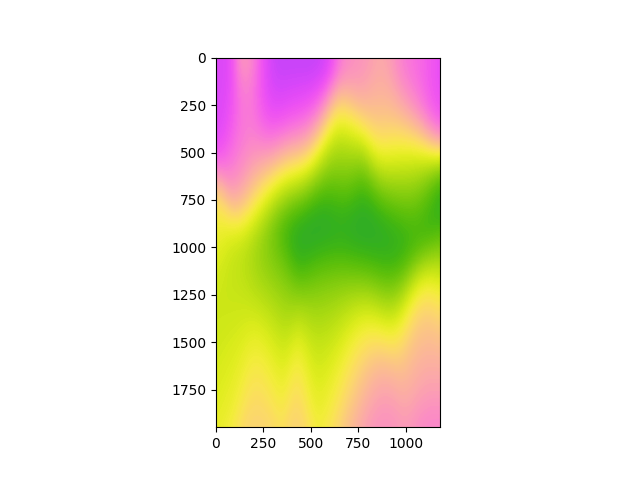

In [169]:
pl.figure()
pl.imshow(azim_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)

In [170]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/figures/caiman-examples'

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


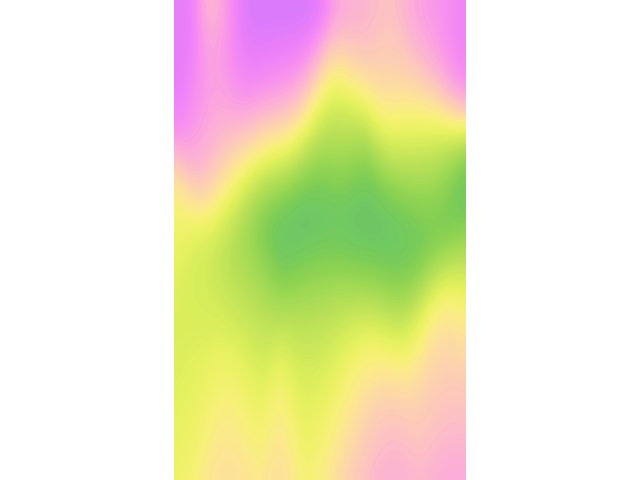

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

<IPython.core.display.Javascript object>


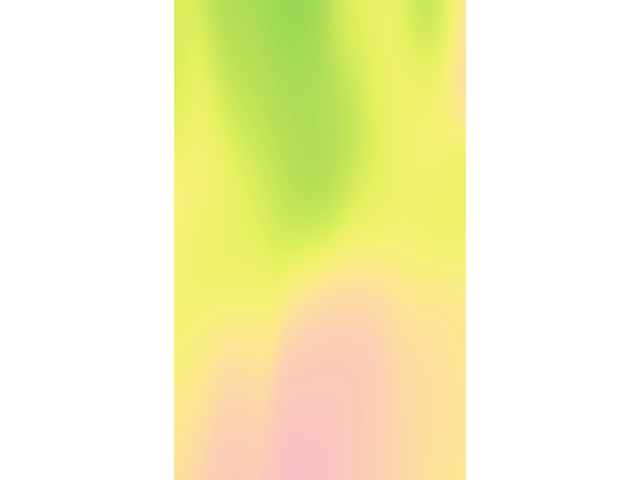

neuropil_absolute-elevation_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [173]:

condition = 'elevation'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

<IPython.core.display.Javascript object>


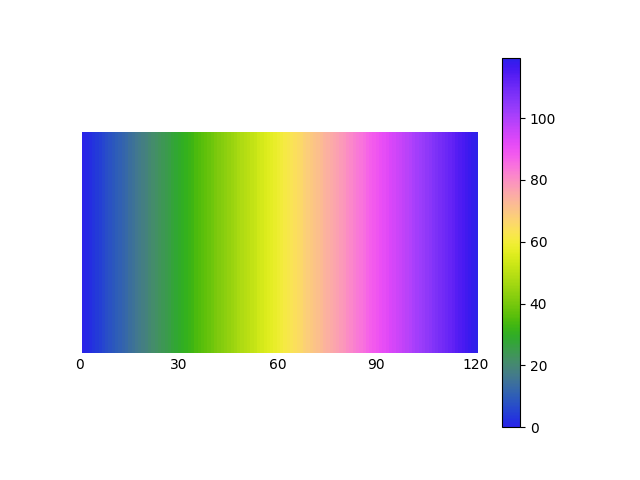

cond2-pos_colorwheel_LEGEND_abs


In [382]:
fig, ax = pl.subplots()
im = ax.imshow(az_screen, cmap=cmap_phase)
#ax.invert_xaxis()
pl.colorbar(im)
ax.set_xticks(np.linspace(0, int(round(screen_x)), 5))
ax.set_xticklabels([int(round(i)) for i in np.linspace(0, int(round(screen_x)), 5)][::-1])

#spos1, epos1 = pos1_deg[0], pos1_deg[-1]
#spos2, epos2 = pos2_deg[0], pos2_deg[-1]

#ax.axvline(x=screen_x-spos1, c='w')
#ax.axvline(x=screen_x-epos1, c='w')

#ax.axvline(x=screen_x-spos2, c='w')
#ax.axvline(x=screen_x-epos2, c='w')

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='x', length=0)
ax.set_frame_on(False)

ax.set_xlim(ax.get_xlim()[::-1])


figname = 'cond2-pos_%s_LEGEND_abs' % (colormap)

pl.savefig(os.path.join(retinodir, '%s.png' % figname))

print figname

# Save legends

<IPython.core.display.Javascript object>


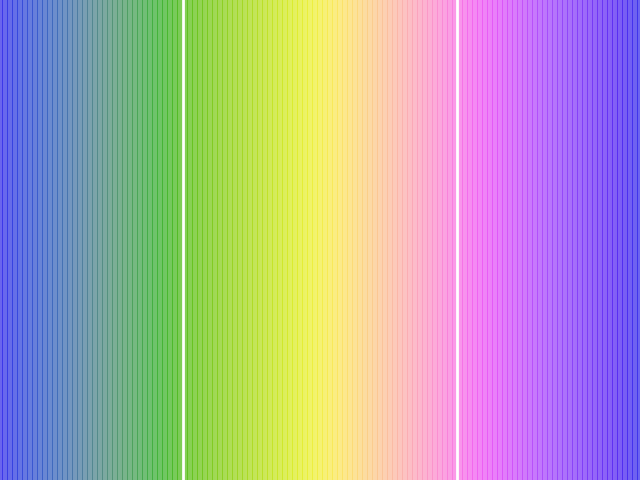

In [117]:
fig = pl.figure()

# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.

cbar1_orientation='horizontal'
cbar1_axes = [0, 0, 1, 1] #[0.31, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

pl.savefig(os.path.join(outdir, 'legend_absolute-azimuth.png')) #% (figname, label_str)))


<IPython.core.display.Javascript object>


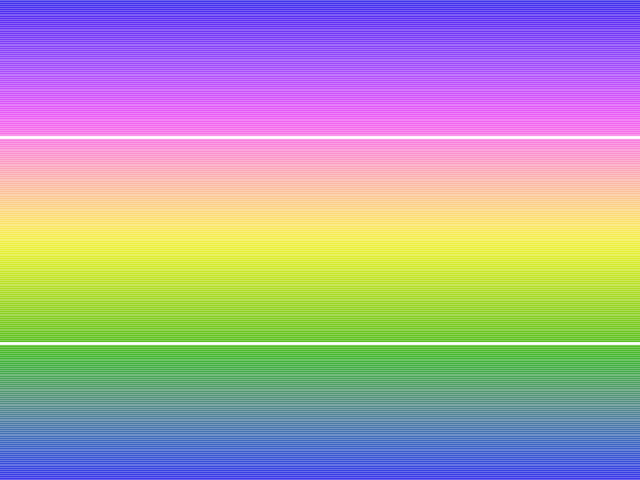

corrected_absolute-elevation_filter-allconds-magthr0.01_174cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [118]:
fig = pl.figure()

cbar2_orientation='vertical'
cbar2_axes = [0, 0, 1, 1] #[0.79, 0.78, 0.1, 0.05]

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)


#label_figure(fig, data_identifier)
pl.savefig(os.path.join(outdir, 'legend_absolute-elevation.png')) #% (figname, label_str)))

print(figname)